#FINAL PROJECT DEEP LEARNING FOR NLP
“The contribution of DL to depression detection”

Student: María Paz Oliva


# DATA SET

I am going to create an ad hoc data set by combining two open dataset already available online:
- Around 2000 tweets from the Sentiment140 dataset. These ones will have label 0 ("no-depression").
- Around 2000 tweets from a Github repository that they had taken with the websraper TWINT using the keyword depression by scraping all tweets in one day span. These ones will have label 1 ("depression").

## TARGET 0 : non-depression tweets

The Sentiment140 dataset.  contains 1,600,000 tweets extracted using the twitter api .  The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment. It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: the id of the tweet 

- date: the date of the tweet

- flag: the query, if there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet

I manually choose only 2000 of them (1000 with label 0 and 1000 with label 4).  

In [ ]:
import pandas as pd

# load the Excel file into a dataframe
file_name_0 = "DATASET-0.xlsx"
sheet_name_0 = "Hoja1"
encoding_0 = 'ISO-8859-1'
df_0 = pd.read_excel(file_name_0, sheet_name=sheet_name_0, header=None)
print(df_0.shape)

(2000, 1)


In [ ]:
# define a function to split the dataframe into multiple columns
def split_df(df):
    # create an empty dataframe with 6 columns
    new_df = pd.DataFrame(columns=['target', 'id', 'date', 'flag', 'user', 'text'])
    # loop over each row of the dataframe
    for index, row in df.iterrows():
        # split the row into multiple values based on the comma separator
        values = row[0].split(',')
        # check if the length of the list of values matches the number of columns in the new dataframe
        if len(values) == len(new_df.columns):
            # create a new row with the split values
            new_row = pd.Series(values, index=new_df.columns)
            # append the new row to the new dataframe
            new_df = new_df.append(new_row, ignore_index=True)
    return new_df

In [ ]:
df_0 = split_df(df_0)
df_0 = df_0.drop(columns=['id', 'date', 'flag', 'user'])

In [ ]:
# count the number of rows with each value in the 'target' column
counts = df_0["target"].value_counts()
# print the counts
print(counts)

# replace all the values in the 'target' column with the value 0
df_0.loc[:, 'target'] = 0
# count the number of rows with each value in the 'target' column
counts = df_0["target"].value_counts()
# print the counts
print(counts)

0    775
4    746
Name: target, dtype: int64
0    1521
Name: target, dtype: int64


In [ ]:
# reorder the columns so that 'text' comes first and 'target' comes second
df_0 = df_0.loc[:, ['text', 'target']]
print(df_0)

                                                   text  target
0     "is upset that he can't update his Facebook by...       0
1     "@Kenichan I dived many times for the ball. Ma...       0
2     "my whole body feels itchy and like its on fire "       0
3                       "@Kwesidei not the whole crew "       0
4                                         "Need a hug "       0
...                                                 ...     ...
1516  "the new songs by the Hot Action Cops seriousl...       0
1517  "@WordyRappinHood I got it  Will call her late...       0
1518                             "@darenBBC good luck "       0
1519      "@DionneSouth Ooooh ..... Gadget Hangovers. "       0
1520                     "@jonasbrothers are on GMTV! "       0

[1521 rows x 2 columns]


## TARGET 1 : depression tweets

This data set was srcaped with TWINT using the keyword depression. 

All tweets were scraped in one day span. 

It has 10 fields, but I will only use the text. 

In [ ]:
# load the file into a dataframe
file_name_1 = "DATASET-1.csv"
col_names_1 = ['id', 'date', 'time', 'time2', 'user', 'text', 'num1', 'num2', 'num3', 'end']
df_1 = pd.read_csv(file_name_1, header=None, sep='|')
df_1.columns = col_names_1

print(df_1.shape)

(1998, 10)


In [ ]:
# drop useless columns
df_1 = df_1.drop(columns=['id', 'date', 'time', 'time2', 'user', 'num1', 'num2', 'num3','end'])
# add a new column 'target' with all values equal to 1
df_1['target'] = 1

In [ ]:
print(df_1)

                                                   text  target
0     The lack of this understanding is a small but ...       1
1     i just told my parents about my depression and...       1
2     depression is something i don't speak about ev...       1
3     Made myself a tortilla filled with pb&j. My de...       1
4     @WorldofOutlaws I am gonna need depression med...       1
...                                                 ...     ...
1993  Am I #Worried? #Yes... It has been a #tough mo...       1
1994  @sosadtoday no i have awful clinical depressio...       1
1995  @AnimeAntisemite he's really probably criticiz...       1
1996  Meet Heidi Piotrowski, founder of hp counselli...       1
1997  actors symptoms of adult depression naked gtee...       1

[1998 rows x 2 columns]


## FINAL FULL DATASET

In [ ]:
# merge the two dataframes into a single dataframe
df = pd.concat([df_0, df_1], ignore_index=True)
# shuffle the dataset
df = df.sample(frac=1) 
# drop rows with missing text values
df = df.dropna(subset=['text'])
# filter out any rows that contain non-string values
df = df[df['text'].notna()]

In [ ]:
print(df)
print(df.shape)

                                                   text  target
843               "@dcostalis that's what I'm finding "       0
2912  How you look at all the incoming freshman exci...       1
619                                "it is really cold "       0
289   "Wait should I eat?? Or be skinny for vegas!! ...       0
1869  Mounting evidence shows exercise can prevent d...       1
...                                                 ...     ...
640   "jealous of my friends who got to see the new ...       0
3321  Our great war is a spiritual war. Our great de...       1
2442  me during the depression hours crying over my ...       1
1884  I have been suffering with depression and anxi...       1
2702  Just, if you think you know someone struggling...       1

[3459 rows x 2 columns]
(3459, 2)


# PRE-PROCESSING

As in the papper and Github followed I wil perform: 
- lowercasing
- tokenization
- remove punctuation, numbers and symbols
- not remove function words

In [ ]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def preprocess(text):
  # remove punctuation, numbers and symbols
  text = re.sub(r'[^\w\s]', '', text)
  # lowercase everything
  text = text.lower()
  # tokenize it
  tokens = word_tokenize(text)
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# apply preprocess function to text column
df['text'] = df['text'].apply(preprocess)

In [ ]:
print(df)

                                                   text  target
843               [dcostalis, thats, what, im, finding]       0
2912  [how, you, look, at, all, the, incoming, fresh...       1
619                              [it, is, really, cold]       0
289   [wait, should, i, eat, or, be, skinny, for, ve...       0
1869  [mounting, evidence, shows, exercise, can, pre...       1
...                                                 ...     ...
640   [jealous, of, my, friends, who, got, to, see, ...       0
3321  [our, great, war, is, a, spiritual, war, our, ...       1
2442  [me, during, the, depression, hours, crying, o...       1
1884  [i, have, been, suffering, with, depression, a...       1
2702  [just, if, you, think, you, know, someone, str...       1

[3459 rows x 2 columns]


In [ ]:
# count the total number of tokens
num_tokens = sum(df['text'].apply(len))
print("Total number of tokens in dataset:", num_tokens)
# get the total number of unique tokens
unique_tokens = set([word for tweet in df['text'] for word in tweet])
num_unique_tokens = len(unique_tokens)
print("Total number of unique tokens in dataset:", num_unique_tokens)

Total number of tokens in dataset: 62408
Total number of unique tokens in dataset: 11018


In [ ]:
# iterate over the rows of the DataFrame and remove 'depression' and 'anxiety' from each list of tokens
df['text'] = [[token for token in row if token != 'depression'] for row in df['text']]
df['text'] = [[token for token in row if token != 'anxiety'] for row in df['text']]

##WORD CLOUD ANALYSIS

I want to create one wordcloud to show most frequent words in the texts with label 0 and one wordcloud that shows most frequent words on the texts whit label 1. 

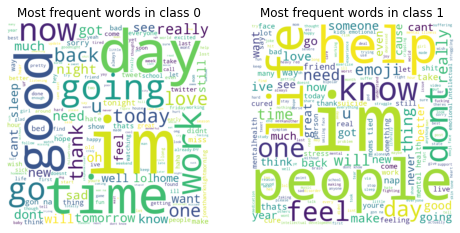

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# split the DataFrame into two based on the label column
df_0_wc = df[df['target'] == 0]
df_1_wc = df[df['target'] == 1]

# convert the preprocessed tokens to a single string for each class
text_0 = ' '.join([word for tweet in df_0_wc['text'] for word in tweet])
text_1 = ' '.join([word for tweet in df_1_wc['text'] for word in tweet])

# generate the wordclouds for each class
wordcloud_0 = WordCloud(width=800, height=800, background_color='white', 
                        min_font_size=10).generate(text_0)
wordcloud_1 = WordCloud(width=800, height=800, background_color='white', 
                        min_font_size=10).generate(text_1)

# display the wordclouds
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in class 0")
plt.subplot(1,2,2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in class 1")
plt.show()

##WORD EMBBEDING

Following the paer I decided to use Glove embedings pre-trained on Twiter. 

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Concatenate, Input, Dot, Activation, Lambda
from keras.layers import Flatten, RepeatVector, Permute
from keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
# tokenize the text using the Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
# load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}

with open('glove.twitter.27B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            pass

In [ ]:
# create an embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# pad the sequences
maxlen = 140
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

# BUILD AND TRAIN THE MODELS

## MODEL 1: BiLTSM model with Attention

Following the paper I build a BiLTSM model with Attention. 
It has 10 layers as it can be seen in the summary. 

In [ ]:
from sklearn.model_selection import train_test_split
# split the data into training, development, and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# build the BiLSTM model with attention

input_layer = Input(shape=(maxlen,))

embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

bilstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

attention_weights = Dense(1, activation='tanh')(bilstm_layer)
attention_weights = Flatten()(attention_weights)
attention_weights = Activation('softmax')(attention_weights)
attention_weights = RepeatVector(128)(attention_weights)
attention_weights = Permute([2, 1])(attention_weights)

sent_representation = Concatenate(axis=-1)([bilstm_layer, attention_weights])

output_layer = Dense(1, activation='sigmoid')(sent_representation)

model_lstm = Model(inputs=[input_layer], outputs=output_layer)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_lstm.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 140)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 140, 100)     1101700     ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 140, 128)    84480       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 dense_6 (Dense)                (None, 140, 1)       129         ['bidirectional_2[0][0]']  

In [ ]:
# train model BiLTSM with Attention
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_lstm.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
18/18 [==============================] - 21s 732ms/step - loss: 0.6765 - accuracy: 0.5446 - val_loss: 0.6507 - val_accuracy: 0.5925
Epoch 2/10
18/18 [==============================] - 10s 559ms/step - loss: 0.6013 - accuracy: 0.6327 - val_loss: 0.4943 - val_accuracy: 0.7714
Epoch 3/10
18/18 [==============================] - 11s 544ms/step - loss: 0.5130 - accuracy: 0.7718 - val_loss: 0.4763 - val_accuracy: 0.7928
Epoch 4/10
18/18 [==============================] - 11s 644ms/step - loss: 0.5090 - accuracy: 0.7705 - val_loss: 0.5043 - val_accuracy: 0.7877
Epoch 5/10
18/18 [==============================] - 11s 627ms/step - loss: 0.5127 - accuracy: 0.7777 - val_loss: 0.4832 - val_accuracy: 0.8012


In [ ]:
# evaluate model BiLTSM with Attention
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

22/22 [==============================] - 1s 53ms/step - loss: 0.5034 - accuracy: 0.7881
Test accuracy: 0.7880883812904358


## MODEL 2: Fine-tuning BERT

In [ ]:
!pip install transformers
import transformers
import tensorflow as tf

In [ ]:
# load the pre-trained BERT base model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = transformers.TFAutoModel.from_pretrained('bert-base-uncased')

In [ ]:
# prepare the preprocessed data for input into the BERT model
MAX_SEQ_LENGTH = 140
X = df['text'].apply(' '.join)
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
train_encodings = tokenizer(list(X_train.values), max_length=MAX_SEQ_LENGTH, padding='max_length', truncation=True)
dev_encodings = tokenizer(list(X_dev.values), max_length=MAX_SEQ_LENGTH, padding='max_length', truncation=True)
test_encodings = tokenizer(list(X_test.values), max_length=MAX_SEQ_LENGTH, padding='max_length', truncation=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),y_train.values)).shuffle(len(X_train)).batch(32)

dev_dataset = tf.data.Dataset.from_tensor_slices((dict(dev_encodings),y_dev.values)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),y_test.values)).batch(32)

In [ ]:
# define a new model for binary classification
input_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_ids')
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32, name='attention_mask')
input_type = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32, name='token_type_ids')

embedding_layer = bert_model({'input_ids': input_layer, 'attention_mask': input_mask, 'token_type_ids': input_type})[1]

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(embedding_layer)

model = tf.keras.Model(inputs=[input_layer, input_mask, input_type],outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# train model BERT
model.fit(train_dataset, epochs=3, validation_data=dev_dataset)

Epoch 1/3
70/70 [==============================] - 4342s 61s/step - loss: 0.4844 - accuracy: 0.7596 - val_loss: 0.3316 - val_accuracy: 0.8556
Epoch 2/3
70/70 [==============================] - 3827s 55s/step - loss: 0.2683 - accuracy: 0.8857 - val_loss: 0.2705 - val_accuracy: 0.8755
Epoch 3/3
70/70 [==============================] - 3954s 57s/step - loss: 0.1422 - accuracy: 0.9494 - val_loss: 0.2267 - val_accuracy: 0.9188


In [ ]:
# evaluate model BERT on the test set
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)

22/22 [==============================] - 382s 17s/step - loss: 0.2473 - accuracy: 0.9046
Test accuracy: 0.9046242833137512
